         Open        High         Low       Close   Adj Close     Volume  \
0  188.130005  190.449997  188.070007  190.300003  159.538895  130011000   
1  191.679993  194.199997  191.479996  194.070007  162.699554  154949000   
2  194.410004  194.910004  192.610001  192.690002  161.542603  151822000   
3  194.619995  196.199997  194.259995  194.929993  163.420502  154944000   
4  195.250000  196.490005  194.490005  196.429993  164.678040  117927000   

        O-C       H-L    Return  Target         SMA         EMA  
0 -2.169998  2.379990  0.009710       1  157.744827  158.153603  
1 -2.390015  2.720001  0.019811       1  158.167609  159.290091  
2  1.720001  2.300003 -0.007111       0  158.799983  159.853219  
3 -0.309998  1.940002  0.011625       1  159.665885  160.745040  
4 -1.179993  2.000000  0.007695       1  160.863532  161.728290  
Training set shape: (2008, 9), Testing set shape: (503, 9)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best model parameters: {'C'

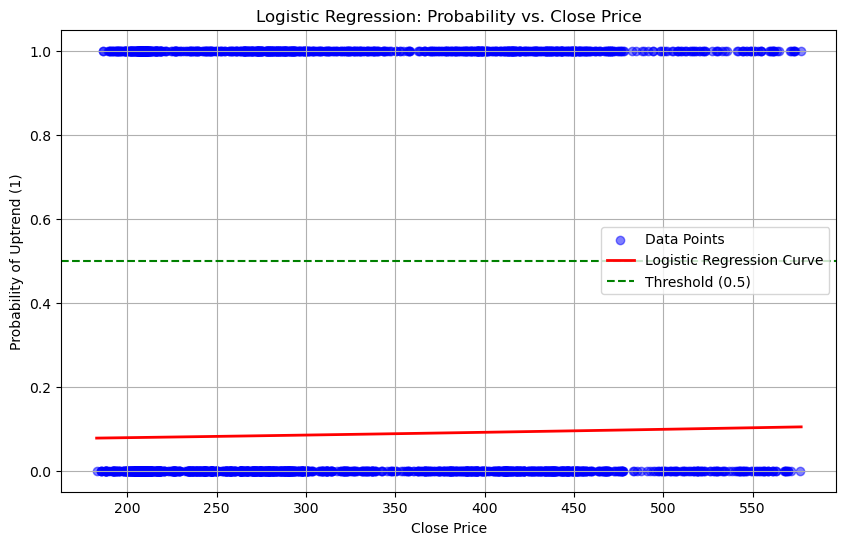

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Step 1: Load the dataset
data = pd.read_csv(r'C:\Users\OneDrive\Documents\final_analysis_dataset.csv')

# Display the first few rows of the dataset
print(data.head())

# Step 2: Define features and target variable
X = data[['Open', 'High', 'Low', 'Close', 'O-C', 'H-L', 'Return', 'SMA', 'EMA']]
y = data['Target']  # Assuming 'Target' is defined as 0 for downtrend and 1 for uptrend

# Step 3: Categorize small near-zero returns
threshold = 0.0025  # Example threshold of 0.25%
y = np.where(data['Return'] < threshold, 0, 1)  # 0 for negative trend, 1 for positive trend

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the training and testing sets
print(f'Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}')

# Step 5: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the SVM model
svm_model = SVC(probability=True)  # Enable probability estimates for ROC curve
svm_model.fit(X_train_scaled, y_train)

# Step 7: Hyperparameter tuning for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],  # Kernel types
    'gamma': ['scale', 'auto']     # Kernel coefficient for RBF kernel
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_svm_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best model parameters:", best_params)

# Step 8: Investigate prediction quality using the best SVM model
y_pred_proba = best_svm_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class
y_pred = best_svm_model.predict(X_test_scaled)  # Class predictions

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation results for SVM
print("AUC (SVM):", roc_auc)
print("Confusion Matrix (SVM):\n", conf_matrix)
print("Classification Report (SVM):\n", class_report)

# Step 9: Train a Logistic Regression model for comparison
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)

# Step 10: Train a Decision Tree model for comparison
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_scaled, y_train)

# Step 11: Create a Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('svm', best_svm_model),
    ('logistic', logistic_model),
    ('dt', decision_tree_model)],
    voting='soft')  # Use 'soft' voting

# Train the voting classifier
voting_clf.fit(X_train_scaled, y_train)

# Step 12: Evaluate the Voting Classifier
y_pred_proba_voting = voting_clf.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class
y_pred_voting = voting_clf.predict(X_test_scaled)  # Class predictions

# Calculate AUC for Voting Classifier
roc_auc_voting = roc_auc_score(y_test, y_pred_proba_voting)

# Generate confusion matrix and classification report for Voting Classifier
conf_matrix_voting = confusion_matrix(y_test, y_pred_voting)
class_report_voting = classification_report(y_test, y_pred_voting)

# Print evaluation results for Voting Classifier
print("AUC (Voting Classifier):", roc_auc_voting)
print("Confusion Matrix (Voting Classifier):\n", conf_matrix_voting)
print("Classification Report (Voting Classifier):\n", class_report_voting)

# Step 13: Plotting the Logistic Regression curve
plt.figure(figsize=(10, 6))

# Create a range of values for the 'Close' price while keeping other features constant
X_range = np.linspace(X['Close'].min(), X['Close'].max(), 100)

# Prepare an array for prediction with constant values for other features
X_test_constant = np.tile(X.mean(), (100, 1))  # Use mean of training data for other features
X_test_constant[:, 3] = X_range  # Set 'Close' price as the varying feature

# Convert to DataFrame for proper scaling
X_test_constant_df = pd.DataFrame(X_test_constant, columns=X.columns)

# Standardize the prepared data using the DataFrame
X_test_constant_scaled = scaler.transform(X_test_constant_df)

# Get the predicted probabilities
y_proba_logistic = logistic_model.predict_proba(X_test_constant_scaled)[:, 1]

# Plot original data
plt.scatter(X['Close'], y, color='blue', label='Data Points', alpha=0.5)
plt.plot(X_range, y_proba_logistic, color='red', linewidth=2, label='Logistic Regression Curve')
plt.title('Logistic Regression: Probability vs. Close Price')
plt.xlabel('Close Price')
plt.ylabel('Probability of Uptrend (1)')
plt.axhline(0.5, color='green', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.grid()
plt.show()


